In [19]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap.umap_ as umap
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [20]:
soloq_games_euw = pd.read_csv("../data/soloq/Europe_stats.csv")
soloq_games_kr = pd.read_csv("../data/soloq/Asia_stats.csv")

soloq_games = pd.concat([soloq_games_euw, soloq_games_kr])

soloq_games = soloq_games.dropna()
# delete games with < 15 mins
soloq_games = soloq_games[soloq_games['gameEndedInEarlySurrender'] == False]
# creates a patch column
soloq_games['patch'] = soloq_games.apply(lambda x: str(x['gameVersion'].split('.')[0] + '.' + x['gameVersion'].split('.')[1]), axis=1 )

In [21]:
relevant_cols = [
    "patch", "teamPosition", "championId", "championName", "gameDuration", "win",
    "neutralMinionsKilled", "totalMinionsKilled", "cs_diff_at_15",
    "champExperience", "xp_diff", "xp_diff_per_min", "xp_per_min_3_15",
    "damageDealtToBuildings", "damageDealtToObjectives", "damageDealtToTurrets", "damageSelfMitigated", "magicDamageDealt", "magicDamageDealtToChampions", "magicDamageTaken",
    "physicalDamageDealt", "physicalDamageDealtToChampions", "physicalDamageTaken", "totalDamageDealt", "totalDamageDealtToChampions", "totalDamageShieldedOnTeammates",
    "totalDamageTaken", "totalHeal", "totalHealsOnTeammates", "totalUnitsHealed", "trueDamageDealt", "trueDamageDealtToChampions", "trueDamageTaken",
    "totalTimeCCDealt", "timeCCingOthers", "totalTimeSpentDead", "dmg_per_minute_diff", "dmg_per_minute_diff_15", "kills", "deaths", "assists", "kill_share", "kill_participation",
    "doubleKills", "tripleKills", "quadraKills", "pentaKills", "firstBloodAssist", "firstBloodKill", "killingSprees", "largestKillingSpree", "largestMultiKill",
    "goldEarned", "goldSpent", "gold_share", "gold_earned_per_min", "gold_diff_15", "gold_10k_time",
    "inhibitorKills", "inhibitorTakedowns", "inhibitorsLost", 
    "itemsPurchased", "consumablesPurchased",
    "largestCriticalStrike", "longestTimeSpentLiving",
    "firstTowerAssist", "firstTowerKill", "objectivesStolen", "objectivesStolenAssists", "turretKills", "turretTakedowns", "turretsLost",
    "sightWardsBoughtInGame", "visionScore", "visionWardsBoughtInGame", "detectorWardsPlaced", "wardsKilled", "wardsPlaced",
    "spell1Casts", "spell2Casts", "spell3Casts", "spell4Casts", "summoner1Casts", "summoner2Casts",
    "lane_proximity", "jungle_proximity", "percent_mid_lane", "percent_side_lanes", "forward_percentage", "counter_jungle_time_percentage",
]


# select only relevant cols
soloq = soloq_games[ relevant_cols ]

In [22]:

def clean_data(df, role = "None", patch = "All", stratified_sampling = False):
    games_df = df
    if patch != "All":
        games_df = games_df[ games_df['patch'] == patch]
    else:
        games_df = games_df
        
    if role != "None":
        games_df = games_df[ games_df['teamPosition'] == role ]
    else:
        games_df = games_df
    # list of champions with more than 100 games played
    top_champs = [i for i, x in games_df.championName.value_counts().to_dict().items() if x > 100]
    games_df = games_df[games_df['championName'].isin(top_champs)]
    if stratified_sampling:
        games_df = games_df.groupby(by='championName').apply(lambda x: x.sample(n=100)).reset_index(level=1, drop=True).drop(['championName'], axis=1).reset_index()
    try:
        games_df = games_df.drop(['teamPosition'], axis=1)
        games_df = games_df.drop(['patch'], axis=1)
        games_df = games_df.drop(['Unnamed: 0'], axis=1)
    except Exception as e:
        print(e)
    return games_df

In [23]:
def kmeans_clustering_elbow(df):
    distorsions = []
    K = range(1, 20)
    for k in K:
        kmean_model = KMeans(n_clusters=k)
        kmean_model.fit(df)
        distorsions.append(kmean_model.inertia_)
        
    plt.figure(figsize=(16,8))
    plt.plot(K, distorsions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [24]:
def group_by_champions(df):
    df_champs = df.drop(['championId'], axis=1).groupby("championName").mean().reset_index(level=0)
    x = df_champs.iloc[:,1:]
    y = df_champs.iloc[:,:1]
    return x, y

In [25]:
role_soloq = clean_data(soloq, role="TOP", patch="12.5")
x_role, y_role = group_by_champions(role_soloq)
# role_soloq_champs = role_soloq.drop(['championId'], axis=1).groupby("championName").mean().reset_index(level=0)
# x_role = role_soloq_champs.iloc[:,1:]
# y_role = role_soloq_champs.iloc[:,:1]

# standarize the data
std_model = StandardScaler()
x_role_std = std_model.fit_transform(x_role)

# PCA
pca = PCA(0.85)
principalComponents = pca.fit_transform(x_role_std)
pca.n_components_


"['Unnamed: 0'] not found in axis"


13

In [31]:
def pca_kmeans(soloq, role="None", patch="12.5", stratified_sampling = False, variance_explained_specified=0.85, k = 2 ):
    role_soloq = clean_data(soloq, role=role, patch=patch, stratified_sampling = stratified_sampling)
    x_role, y_role = group_by_champions(role_soloq)
    ## standarize
    role_std_model = StandardScaler()
    x_role_std = role_std_model.fit_transform(x_role)
    ## pca
    pca = PCA( variance_explained_specified )
    role_principal_components = pca.fit_transform(x_role_std)
    ## k-means
    # kmeans_clustering_elbow(role_principal_components)
    role_kmeans_model = KMeans(n_clusters= k ).fit(role_principal_components)
    y_role['kmeans'] = role_kmeans_model.predict(role_principal_components)
    role_champions_list = y_role.groupby('kmeans')['championName'].apply(list).to_dict()
    
    return role_champions_list, role_principal_components

"['Unnamed: 0'] not found in axis"


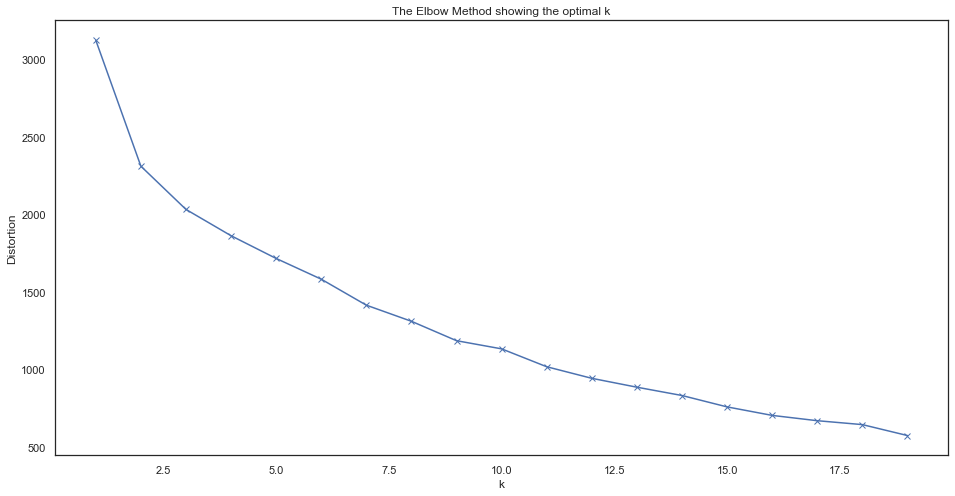

In [35]:
top_champions_list, top_principal_components = pca_kmeans(soloq, role="TOP", patch="12.5", stratified_sampling = False, variance_explained_specified=0.85, k = 2 )
kmeans_clustering_elbow(top_principal_components)

In [ ]:
##### TOP
top_soloq = clean_data(soloq, role="TOP", patch="12.5")
x_top, y_top = group_by_champions(top_soloq)
## standarize
top_std_model = StandardScaler()
x_top_std = top_std_model.fit_transform(x_top)
## pca
pca = PCA(0.85)
top_principal_components = pca.fit_transform(x_role_std)
## k-means
# kmeans_clustering_elbow(top_principal_components)
top_k = 2
top_kmeans_model = KMeans(n_clusters= top_k ).fit(top_principal_components)
y_top['kmeans'] = top_kmeans_model.predict(top_principal_components)
top_champions_list = y_top.groupby('kmeans')['championName'].apply(list).to_dict()


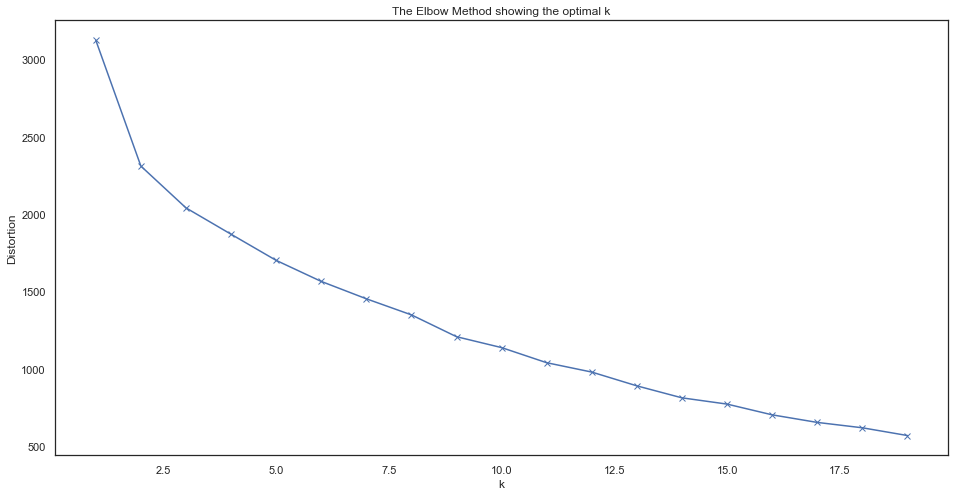

In [26]:
kmeans_clustering_elbow(principalComponents)

In [27]:
global_kmeans_model = KMeans(n_clusters=2).fit(principalComponents)
y_role['kmeans'] = global_kmeans_model.predict(principalComponents)

y_role_list = y_role.groupby('kmeans')['championName'].apply(list).to_dict()

class_1 = pd.unique(y_role[y_role['kmeans'] == 0]['championName'])
class_2 = pd.unique(y_role[y_role['kmeans'] == 1]['championName'])
# class_3 = pd.unique(y_role[y_role['kmeans'] == 2]['championName'])
# class_4 = pd.unique(y_role[y_role['kmeans'] == 3]['championName'])
# class_5 = pd.unique(y_role[y_role['kmeans'] == 4]['championName'])
# class_6 = pd.unique(y_role[y_role['kmeans'] == 5]['championName'])




# for x in class_1:
#     print(x)
# print("")
# print("")
# print("")
# for x in class_2:
#     print(x)
# print("")
# print("")
# print("")
# for x in class_3:
#     print(x)
# print("")
# print("")
# print("")
# for x in class_4:
#     print(x)
# print("")
# print("")
# print("")
# for x in class_5:
#     print(x)

### Top Laners

In [9]:
top_soloq = clean_data(soloq, role="TOP", patch="12.5")
top_soloq.shape[0]

"['Unnamed: 0'] not found in axis"


13551

In [10]:
top_soloq

,championId,championName,gameDuration,win,neutralMinionsKilled,totalMinionsKilled,cs_diff_at_15,champExperience,xp_diff,xp_diff_per_min,...,spell3Casts,spell4Casts,summoner1Casts,summoner2Casts,lane_proximity,jungle_proximity,percent_mid_lane,percent_side_lanes,forward_percentage,counter_jungle_time_percentage
0,150,Gnar,1970,True,6,174,-17,16839,781,0.396447,...,29,4,4,5,0.250000,0.750000,0.083333,0.166667,1.000000,0.750000
5,85,Kennen,1970,False,8,175,17,16058,-781,-0.396447,...,87,12,4,4,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
43,43,Karma,1955,True,8,149,31,14515,-1361,-0.696164,...,189,60,5,7,0.250000,0.750000,0.000000,0.250000,0.916667,0.750000
48,92,Riven,1955,False,8,162,-31,15876,1361,0.696164,...,150,16,5,4,0.250000,0.750000,0.083333,0.166667,0.000000,0.000000
94,68,Rumble,2122,True,24,199,-1,18161,3465,1.632893,...,180,14,4,7,0.500000,0.500000,0.166667,0.333333,0.916667,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166487,114,Fiora,1476,False,4,202,5,12059,-5488,-3.718157,...,43,6,3,4,0.166667,0.833333,0.000000,0.166667,1.000000,0.833333
166492,23,Tryndamere,1476,True,28,197,-5,17547,5488,3.718157,...,96,4,3,4,0.083333,0.916667,0.000000,0.083333,0.166667,0.166667
166507,92,Riven,1316,True,12,162,28,12952,3289,2.499240,...,103,17,3,4,0.250000,0.750000,0.083333,0.166667,1.000000,0.750000
166527,126,Jayce,1497,True,16,172,9,13761,2023,1.351369,...,72,123,4,3,0.250000,0.750000,0.083333,0.166667,0.833333,0.583333


In [17]:
top_soloq_champs = top_soloq.drop(['championId'], axis=1).groupby("championName").mean().reset_index(level=0)
top_soloq_champs

,championName,gameDuration,win,neutralMinionsKilled,totalMinionsKilled,cs_diff_at_15,champExperience,xp_diff,xp_diff_per_min,xp_per_min_3_15,...,spell3Casts,spell4Casts,summoner1Casts,summoner2Casts,lane_proximity,jungle_proximity,percent_mid_lane,percent_side_lanes,forward_percentage,counter_jungle_time_percentage
0,Aatrox,1585.051852,0.478307,13.689947,167.861376,1.207407,13354.232804,82.562963,0.049252,29.066902,...,107.704762,8.584127,3.682540,3.608466,0.229622,0.778844,0.109977,0.119645,0.505191,0.386792
1,Akali,1558.976068,0.505983,3.709402,166.340171,0.181197,13157.391453,78.119658,0.060037,29.236042,...,65.680342,16.786325,4.025641,3.649573,0.245295,0.779207,0.130513,0.114782,0.522978,0.398165
2,Akshan,1625.066176,0.507353,10.338235,175.080882,1.536765,13688.176471,-123.933824,-0.105289,27.305958,...,108.970588,8.095588,4.011029,4.319853,0.281391,0.725962,0.128936,0.152456,0.489937,0.356170
3,Camille,1559.704459,0.513376,6.954140,164.513376,-6.936306,13047.078981,-14.492994,-0.006497,28.513447,...,80.750318,6.281529,3.766879,3.778344,0.235456,0.805308,0.115082,0.120374,0.517672,0.392214
4,Darius,1557.160305,0.498728,11.081425,175.346056,3.155216,12948.977099,-203.066158,-0.120450,29.265679,...,14.709924,6.356234,3.977099,4.055980,0.249342,0.750658,0.115395,0.133947,0.508270,0.382903
5,Fiora,1577.860034,0.492411,8.192243,176.585160,2.303541,13358.234401,81.119730,0.027643,28.361598,...,47.338954,7.258010,3.725126,3.627319,0.237256,0.782980,0.113495,0.123761,0.469598,0.356438
6,Gangplank,1625.389423,0.485577,10.274038,194.173077,1.478365,14175.257212,96.620192,0.059431,27.400330,...,100.937500,7.076923,3.478365,3.278846,0.228767,0.759214,0.099978,0.128789,0.491665,0.372256
7,Garen,1605.136842,0.563158,11.636842,187.789474,-11.873684,14307.568421,433.715789,0.251175,28.634174,...,70.857895,6.136842,3.563158,4.315789,0.213158,0.786842,0.099123,0.114035,0.526404,0.412719
8,Gnar,1532.444620,0.495253,9.965190,173.254747,2.674051,13129.436709,121.498418,0.043002,29.520723,...,29.227848,6.623418,3.055380,3.039557,0.228716,0.820335,0.116579,0.112137,0.554499,0.438528
9,Gragas,1564.724696,0.449393,6.481781,158.979757,-8.190283,12830.230769,-519.182186,-0.338705,29.734099,...,74.554656,9.805668,3.336032,3.445344,0.215536,0.816853,0.109261,0.106275,0.533912,0.419284


In [42]:
x_top = top_soloq_champs.iloc[:,1:]
y_top = top_soloq_champs.iloc[:,:1]

# standarize the data
std_model = StandardScaler()
x_top_std = std_model.fit_transform(x_top)

# PCA
pca = PCA(0.85)
principalComponents = pca.fit_transform(x_top_std)
pca.n_components_

12

In [44]:
def kmeans_clustering_elbow(df):
    distorsions = []
    K = range(1, 20)
    for k in K:
        kmean_model = KMeans(n_clusters=k)
        kmean_model.fit(df)
        distorsions.append(kmean_model.inertia_)
        
    plt.figure(figsize=(16,8))
    plt.plot(K, distorsions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()